In [1]:
IRdisplay::display_html(file='code_hiding.html')

Toggle ON/OFF 
code cells.

In [2]:
# USEFUL COMMAND!
# example(data.table)

In [3]:
# load packages and define constants
library(data.table)     # see https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html for reference
library(ggplot2)        # for plots
library(repr)           # for resizing figures
library(OneR)           # to use the function 'bin'
source("R_functions.r") # custom functions

# folder/file-specific constants
PILOT_NUMBER <- 8
DATA_FOLDER <- "~/programing/data/psychophys/"
FIRA_TAG <- "FIRA"
FRAMES_TAG <- "framesInfo"
DOTS_TAG <- "dotsPositions"

# key-specific constants 
TRIALS <- "trials"
FRAMES <- "frames"
DOTS <- "dots"

# plot-specific constants
AXES_LABEL_FONT <- 18
AXES_FONT <- 15

# other variables
FRAME_RATE_ESTIMATE <- 60 # Hz
FRAME_DURATION <- (1 / FRAME_RATE_ESTIMATE) # sec

In [4]:
# load csv files into data.tables
tb <- list(
    loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FIRA_TAG),
    loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FRAMES_TAG),
    loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, DOTS_TAG))
names(tb) <- c(TRIALS, FRAMES, DOTS)

# add a trialCount column to the TRIALS and FRAMES table
tb[[TRIALS]][,trialCount:=.I]
tb[[FRAMES]] <- tb[[FRAMES]][tb[[TRIALS]][,.(trialCount, trialIndex)],on="trialIndex"]
# add all the fields from the TRIALS table to the DOTS table for Reverse Kernel analysis
tb[[DOTS]] <- tb[[DOTS]][tb[[TRIALS]],on="trialCount"]
# str(tb[[DOTS]])

# Introduction
## Notebook's goals

Analyze data collected on myself. Two subgoals:
1. make sure the task and stimulus behave as we want, to the smallest detail
2. start building up an analysis pipeline for the actual study

## A word on the data for this notebook
The tag for this data is `Pilot 8`. It was collected in the psychophysics booth with [this code](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/releases/tag/pilot8.mat).


## Workflow description
1. Task is run with repo [SingleCP_DotsReversal_Task](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/) (appropriate branch must be chosen).
  1. A `.mat` data file is outputted
  2. I usually manually rename this file `pilot_#.mat` and upload it to PennBox (Data/Psychophysics/Radillo_SingleCP_DotsReversal/)
2. Data is analyzed with repo [SingleCP_DotsReversal_DataAnalaysis](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis)(again, with the appropriate branch).
  1. The first step is to convert data from the .mat file into CSV format with [this script](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/blob/02109ab98b956f2aad4ac15f01e1d373260c8af0/MATLAB_scripts/mat2csv.m) 
    - `pilot#_framesInfo.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-description-of-*framesInfo.csv-file).
    - `pilot#_FIRA.csv`  [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-Description-of-*FIRA.csv-files).
    - `pilot#_dotsPositions.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-descriptions-for-*dotsPositions.csv-file).

**TO-DO**
- Write detailed explanation of each column in each `.csv` file (i.e. update the [Wiki](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki))
- Make sure data from the three `.csv` files is consistent

## Specific questions
1. How many frames are skipped on each trial, and where in the trial do they occur?
2. Does this number match the offset in viewing duration per trial?
3. Compute reverse kernels with the number of coherent dots as a proxy for motion energy

# Exploring the data
## The `*FIRA.csv` file (trials level)

In [5]:
# for this particular dataset, the timestamps of most columns have the wrong offset. This bug has been fixed since.
# for now, we still need to manually correct the time values as follows:
wideTimestamps <- tb[[TRIALS]][,.(trialStart=trialStart-trialStart,
                                  trialEnd=trialEnd-trialStart,
                                  dotsOn,
                                  dotsOff,
                                  tocDotsOn,
                                  tocDotsOff,
                                  nDotsOn=dotsOn - tocDotsOn,
                                  nDotsOff=dotsOff - tocDotsOn,
                                  nTocDotsOn=tocDotsOn - tocDotsOn,
                                  nTocDotsOff=tocDotsOff - tocDotsOn,
                                  targetOn,
                                  fixationOn,
                                  choiceTime,
                                  trialCount,
                                  presenceCP),by=trialIndex]
str(tb[[TRIALS]])

Classes ‘data.table’ and 'data.frame':	54 obs. of  28 variables:
 $ taskID         : int  2 2 2 2 2 2 2 2 2 2 ...
 $ trialIndex     : int  39 24 35 37 53 1 45 8 12 27 ...
 $ trialStart     : num  175622 175628 175632 175637 175642 ...
 $ trialEnd       : num  175628 175632 175637 175642 175646 ...
 $ RT             : num  1.256 0.915 1.091 1.765 1.26 ...
 $ choice         : int  0 0 0 0 1 0 1 1 1 0 ...
 $ correct        : int  0 0 1 1 0 1 0 0 0 1 ...
 $ initDirection  : int  0 0 0 180 180 180 180 180 180 180 ...
 $ endDirection   : int  0 0 180 180 180 180 180 180 180 180 ...
 $ presenceCP     : int  0 0 1 0 0 0 0 0 0 0 ...
 $ coherence      : num  12.8 25.6 25.6 6.4 25.6 6.4 12.8 6.4 25.6 12.8 ...
 $ viewingDuration: num  0.1 0.1 0.3 0.1 0.3 0.1 0.2 0.2 0.2 0.2 ...
 $ probCP         : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ timeCP         : num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ randSeedBase   : int  939 6340 8210 4896 8965 2466 4585 9947 8847 8066 ...
 $ fixa

## The `*framesInfo.csv` file (frames level)

In [6]:
str(tb[[FRAMES]])

Classes ‘data.table’ and 'data.frame':	960 obs. of  7 variables:
 $ frameTotCount: int  3 4 5 6 7 8 9 10 11 12 ...
 $ onsetTime    : num  175623 175625 175625 175625 175625 ...
 $ onsetFrame   : int  222 353 363 371 372 373 528 583 615 616 ...
 $ swapTime     : num  175623 175625 175625 175625 175625 ...
 $ isTight      : int  0 0 0 0 1 1 0 0 0 1 ...
 $ trialIndex   : int  39 39 39 39 39 39 24 24 24 24 ...
 $ trialCount   : int  1 1 1 1 1 1 2 2 2 2 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## The `*dotsPositions.csv` file (dots level)

In [7]:
str(tb[[DOTS]])
#tb[[DOTS]][,.(.N),by=.(frameIdx,trialCount)]

Classes ‘data.table’ and 'data.frame':	135226 obs. of  33 variables:
 $ xpos           : num  0.0534 0.7668 0.4649 0.3886 0.7315 ...
 $ ypos           : num  0.751 0.988 0.291 0.84 0.375 ...
 $ isActive       : int  1 0 0 1 0 0 1 0 0 1 ...
 $ isCoherent     : int  1 0 0 1 0 0 1 0 0 1 ...
 $ frameIdx       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialCount     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ taskID         : int  2 2 2 2 2 2 2 2 2 2 ...
 $ trialIndex     : int  39 39 39 39 39 39 39 39 39 39 ...
 $ trialStart     : num  175622 175622 175622 175622 175622 ...
 $ trialEnd       : num  175628 175628 175628 175628 175628 ...
 $ RT             : num  1.26 1.26 1.26 1.26 1.26 ...
 $ choice         : int  0 0 0 0 0 0 0 0 0 0 ...
 $ correct        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ initDirection  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ endDirection   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ presenceCP     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ coherence      : num  12.8 12.8 12.8 12.8 12.8 12.8 12.8 12.8 12.8 12.8 ...

# Timing Tests
- How long did the session last?

In [8]:
cat( round(tb[[TRIALS]][,sum(trialEnd - trialStart)] / 60, digits = 2), "min" )

3.61 min

- How many trials were produced?

In [9]:
numTrials <- length(unique(tb[[TRIALS]]$trialIndex))
# display warning if somehow a trial or more are duplicated
duplicates <- numTrials != nrow(tb[[TRIALS]])
if (duplicates) {
  print("some trials are duplicated -- remainder of notebook should NOT be executed")
} else {
  cat(numTrials, "trials")
}

54 trials

- How many trials were produced per combination of factors?

In [10]:
indepVarNames <- c("initDirection","presenceCP","coherence","viewingDuration","probCP","timeCP")
combFactors <- getFreq(tb[[TRIALS]], indepVarNames)
combFactors

initDirection,presenceCP,coherence,viewingDuration,probCP,timeCP,freq.
0,0,12.8,0.1,0.5,0.2,2
0,0,25.6,0.1,0.5,0.2,2
0,1,25.6,0.3,0.5,0.2,2
180,0,6.4,0.1,0.5,0.2,5
180,0,25.6,0.3,0.5,0.2,4
180,0,12.8,0.2,0.5,0.2,6
180,0,6.4,0.2,0.5,0.2,6
180,0,25.6,0.2,0.5,0.2,6
180,1,6.4,0.3,0.5,0.2,2
0,0,6.4,0.1,0.5,0.2,1


- What were the marginal frequencies?

In [11]:
for (i in 1:length(indepVarNames)) {
  print(getFreq(tb[[TRIALS]], indepVarNames[i]))
}

   initDirection freq.
1:             0    11
2:           180    43
   presenceCP freq.
1:          0    47
2:          1     7
   coherence freq.
1:      12.8    18
2:      25.6    18
3:       6.4    18
   viewingDuration freq.
1:             0.1    18
2:             0.3    18
3:             0.2    18
   probCP freq.
1:    0.5    54
   timeCP freq.
1:    0.2    54


## A deeper look at the timestamps fields

In [12]:
# refTime <- wideTimestamps[,.(trialCount,
#     trialStart, trialEnd, dotsOn, dotsOff, targetOn, fixationOn, choiceTime), 
#                         by=trialIndex]
longTimestamps <- melt(wideTimestamps,
                       id.vars=c("trialCount"),
                       measure.vars=c("trialStart","fixationOn","targetOn","dotsOn","dotsOff",
                                      "choiceTime","trialEnd"),
                       value.name="timestamp", variable.name="Event")
str(longTimestamps)

Classes ‘data.table’ and 'data.frame':	378 obs. of  3 variables:
 $ trialCount: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Event     : Factor w/ 7 levels "trialStart","fixationOn",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ timestamp : num  0 0 0 0 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


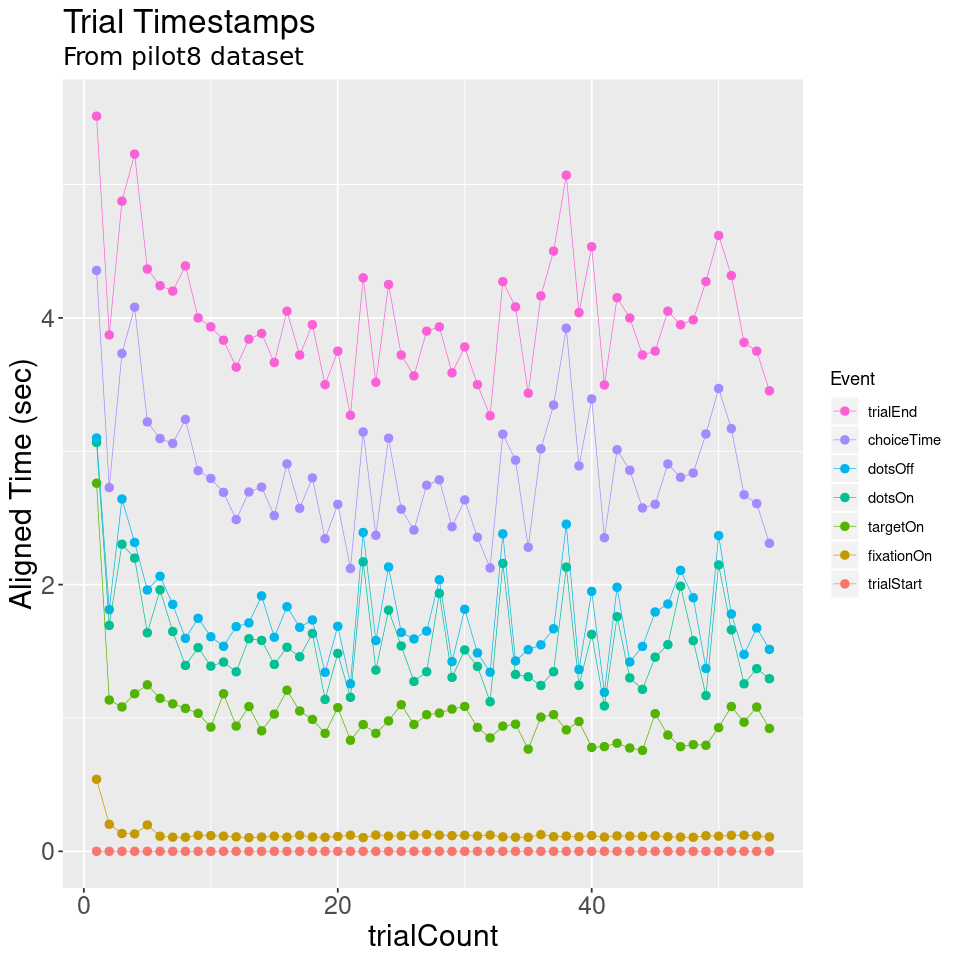

In [13]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=8)
# plot
ggplot(longTimestamps, aes(x=trialCount, y=timestamp)) + geom_point(aes(col=Event), size=2) +
   geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    guides(colour = guide_legend(reverse=T)) +
    labs(title="Trial Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="Aligned Time (sec)") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

- How precise were the dots timings?  

We plot `(dotsOff - dotsOn) - viewingDuration`, across all trials, and overlay average durations of 1 and 2 frames (dashed lines).

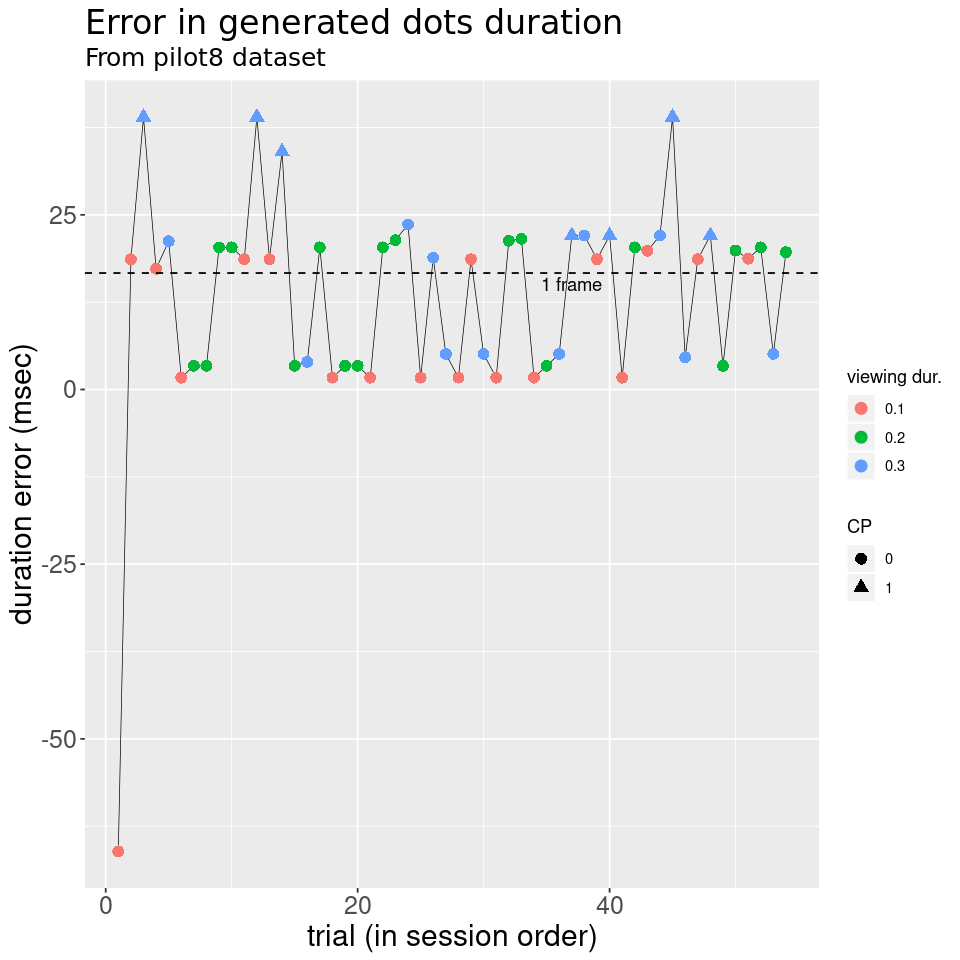

In [14]:
durTable <- tb[[TRIALS]][,.(dotsDurationError = (dotsOff - dotsOn - viewingDuration) * 1000, 
                            presenceCP, 
                            viewingDuration), 
                        by=trialCount]
# str(durTable)
# call to ggplot()
g <- ggplot(durTable, aes(x=trialCount, y=dotsDurationError)) + 
  geom_line(size=.2) +  
  geom_point(aes(shape=factor(presenceCP), col=factor(viewingDuration)),size=3) +
  geom_hline(yintercept = FRAME_DURATION*1000, linetype="dashed") +
  annotate("text", x=37, y=FRAME_DURATION*1000, vjust = 1.3, label = c("1 frame"))
# Add Title and Labels
g + labs(title="Error in generated dots duration", 
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""), 
         y="duration error (msec)", 
         x="trial (in session order)",
         color="viewing dur.", shape="CP") + theme(plot.title=element_text(size=20, 
                                    family="American Typewriter",
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, 
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

Below I specifically compare the `dotsOn` and `dotsOff` values that I got from the task and from the `tic/toc` calls.

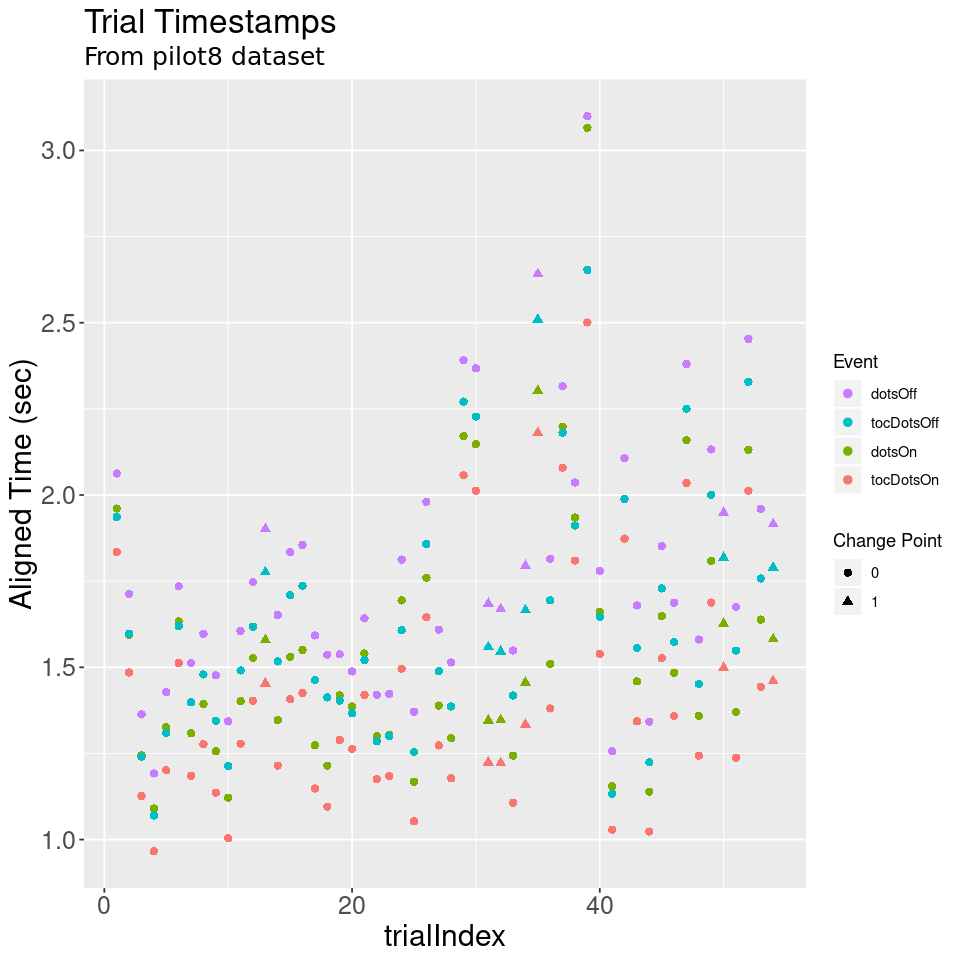

In [15]:
longDotsOffTimestamps <- melt(wideTimestamps,
                       id.vars=c("trialIndex","presenceCP"),
                       measure.vars=c("tocDotsOn","dotsOn","tocDotsOff","dotsOff"),
                       value.name="timestamp", variable.name="Event")

# control output figure size
options(repr.plot.width=8, repr.plot.height=8)

# plot
ggplot(longDotsOffTimestamps, aes(x=trialIndex, y=timestamp)) + 
   geom_point(aes(col=Event, shape=factor(presenceCP)), size=2) +
#    geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    guides(colour = guide_legend(reverse=T)) +
    labs(title="Trial Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="Aligned Time (sec)",
        shape="Change Point") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

In [16]:
intervals <- bin(durTable[,.(dotsDurationError)], nbins = 3, method = "cluster")
names(intervals) <- "interval"

# add the bins as a factor to the data.table
durTable[, ("interval") := intervals]

# compute mean durations
unordered <- durTable[, .(num_trials=.N, meanDurationError = mean(dotsDurationError)), by = intervals]

# display results, with num_frame column
unordered[order(meanDurationError),.(num_trials, meanDurationError, num_frames = (meanDurationError * FRAME_RATE_ESTIMATE / 1000))]

num_trials,meanDurationError,num_frames
1,-66.101695,-3.9661017
21,3.150722,0.1890433
32,22.448391,1.3469034


# Checking that the three datasets are consistent
As we can see, the `frameIdx` field is common to `tb[[FRAMES]]` and `tb[[DOTS]]`, and the `trialIdx` is common to `tb[[DOTS]]` and `tb[[TRIALS]]`. Let's check whether these common fields match in terms of their unique values in each dataset.

## Exploring match between `DOTS` and `TRIALS` levels

## Exploring match between `FRAMES` and `TRIALS` levels
### Timing of trial vs. timing of frames

In [17]:
# add (bug-corrected) dotsOn, dotsOff values to filter swapTimes
# add trialStart for future offset
# the syntax is that of a right join
frameTimes <- tb[[FRAMES]][tb[[TRIALS]][,.(trialStart, 
                                           dotsOn, 
                                           dotsOff, 
                                           trialIndex)], on="trialIndex"]

# only consider frames with swapTime in-between dotsOn and dotsOff
frameTimes <- frameTimes[onsetTime-trialStart>=dotsOn & onsetTime-trialStart <= dotsOff]
str(frameTimes)

Classes ‘data.table’ and 'data.frame':	741 obs. of  10 variables:
 $ frameTotCount: int  6 7 12 13 14 15 16 17 18 23 ...
 $ onsetTime    : num  175625 175625 175630 175630 175630 ...
 $ onsetFrame   : int  371 372 616 617 618 619 620 621 622 881 ...
 $ swapTime     : num  175625 175625 175630 175630 175630 ...
 $ isTight      : int  0 1 1 1 1 1 1 1 1 1 ...
 $ trialIndex   : int  39 39 24 24 24 24 24 24 24 35 ...
 $ trialCount   : int  1 1 2 2 2 2 2 2 2 3 ...
 $ trialStart   : num  175622 175622 175628 175628 175628 ...
 $ dotsOn       : num  3.07 3.07 1.69 1.69 1.69 ...
 $ dotsOff      : num  3.1 3.1 1.81 1.81 1.81 ...
 - attr(*, ".internal.selfref")=<externalptr> 


- does the "number of frames" match across the three files?

In [18]:
setkey(frameTimes, trialIndex)
setkey(tb[[TRIALS]], trialIndex)

# Full OUTER JOIN (see https://rstudio-pubs-static.s3.amazonaws.com/52230_5ae0d25125b544caab32f75f0360e775.html)
frameCount <- merge(
    tb[[TRIALS]][,.(numInTRIALS=numFrames, trialCount),by=trialIndex],
    frameTimes[,.(numInFRAMES=.N),by=trialIndex],
    all=TRUE)

str(frameCount)

Classes ‘data.table’ and 'data.frame':	54 obs. of  4 variables:
 $ trialIndex : int  1 2 3 4 5 6 7 8 9 10 ...
 $ numInTRIALS: int  11 12 12 11 11 12 18 18 18 17 ...
 $ trialCount : int  6 13 39 41 34 18 35 8 52 32 ...
 $ numInFRAMES: int  7 8 8 7 7 8 14 14 14 13 ...
 - attr(*, "sorted")= chr "trialIndex"
 - attr(*, ".internal.selfref")=<externalptr> 


In [19]:
frameCount <- frameCount[tb[[DOTS]][order(trialIndex),.(numInDOTS=max(frameIdx)),by=trialIndex],on="trialIndex"]
frameCount[,.(trialIndex, trialCount, numInTRIALS,numInFRAMES,numInDOTS,match=numInFRAMES == numInDOTS)]

trialIndex,trialCount,numInTRIALS,numInFRAMES,numInDOTS,match
1,6,11,7,7,TRUE
2,13,12,8,8,TRUE
3,39,12,8,8,TRUE
4,41,11,7,7,TRUE
5,34,11,7,7,TRUE
6,18,12,8,8,TRUE
7,35,18,14,14,TRUE
8,8,18,14,14,TRUE
9,52,18,14,14,TRUE
10,32,17,13,13,TRUE


From the columns above, we see that:
- the `numFrames` field from the `tb[[TRIALS]]` table is not useful
- I should match dots and frames using timestamps

- what time gaps do I observe between `dotsOn` and 1st frame `onsetTime`, and last frame `onsetTime` and `dotsOff`?

In [20]:
# get times of first and last frame in each trial, align everything to dotsOn
extremeFrameTimes <- frameTimes[,.(firstFrame=min(onsetTime-trialStart)-dotsOn, 
                                   lastFrame=max(onsetTime-trialStart)-dotsOn,
                                   trialStart, 
                                   dotsOn=dotsOn-dotsOn, 
                                   dotsOff=dotsOff-dotsOn,
                                   trialCount),
                                  by=trialIndex]
str(extremeFrameTimes)

Classes ‘data.table’ and 'data.frame':	741 obs. of  7 variables:
 $ trialIndex: int  1 1 1 1 1 1 1 2 2 2 ...
 $ firstFrame: num  3.05e-05 3.05e-05 3.05e-05 3.05e-05 3.05e-05 ...
 $ lastFrame : num  0.0848 0.0848 0.0848 0.0848 0.0848 ...
 $ trialStart: num  175646 175646 175646 175646 175646 ...
 $ dotsOn    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ dotsOff   : num  0.102 0.102 0.102 0.102 0.102 ...
 $ trialCount: int  6 6 6 6 6 6 6 13 13 13 ...
 - attr(*, "sorted")= chr "trialIndex"
 - attr(*, ".internal.selfref")=<externalptr> 


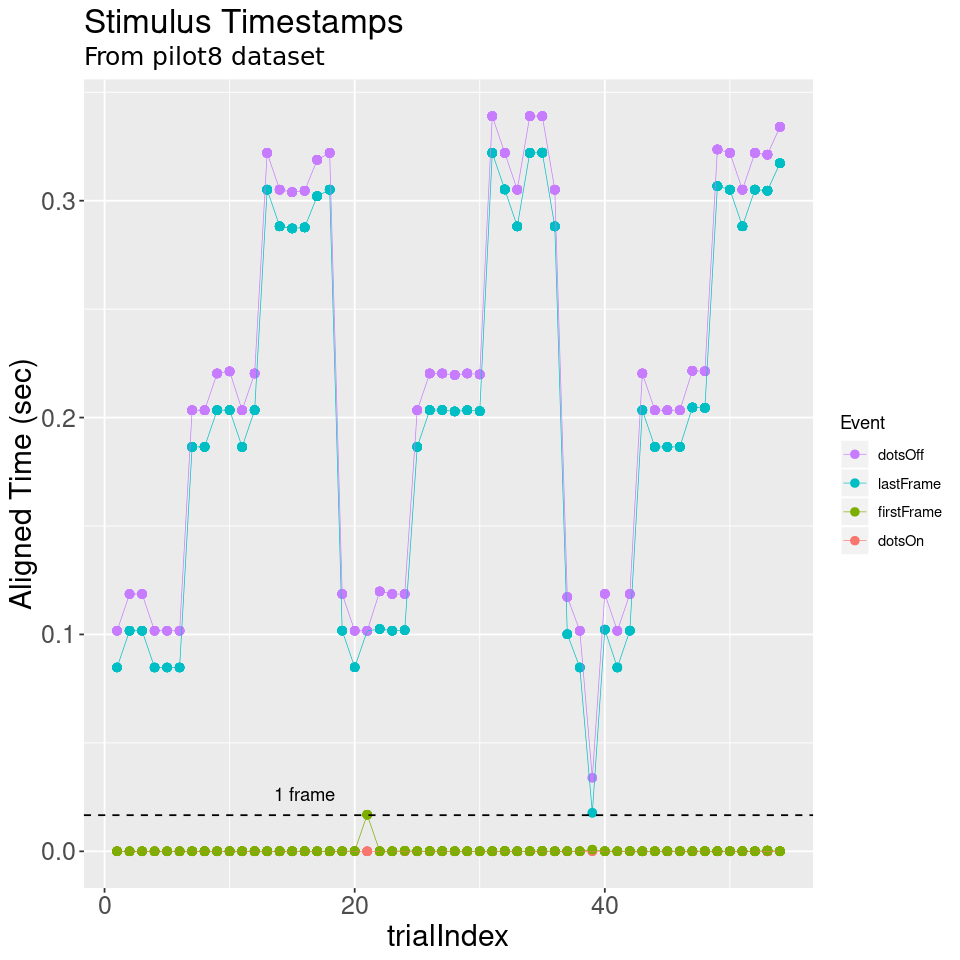

In [21]:
# transform to long format for ggplot 
longTimeData <- melt(extremeFrameTimes, 
                    id.vars=c("trialIndex"),
                    measure.vars=c("dotsOn","firstFrame","lastFrame","dotsOff"),
                    variable.name="Event", value.name="timestamp")
#str(longTimeData)


frameDurations <- c(6*FRAME_DURATION, 140*FRAME_DURATION)

# control output figure size
options(repr.plot.width=8, repr.plot.height=8)

# plot
ggplot(longTimeData, aes(x=trialIndex, y=timestamp)) + geom_point(aes(col=Event), size=2) +
   geom_line(aes(col=Event),size=.2) +
   geom_hline(yintercept = FRAME_DURATION, linetype="dashed") +
   annotate("text", x=16, y=FRAME_DURATION, vjust = -1, label = c("1 frame")) +
   guides(colour = guide_legend(reverse=T)) +
   labs(title="Stimulus Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="Aligned Time (sec)") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

- Exploration of `Tight` frames in each trial

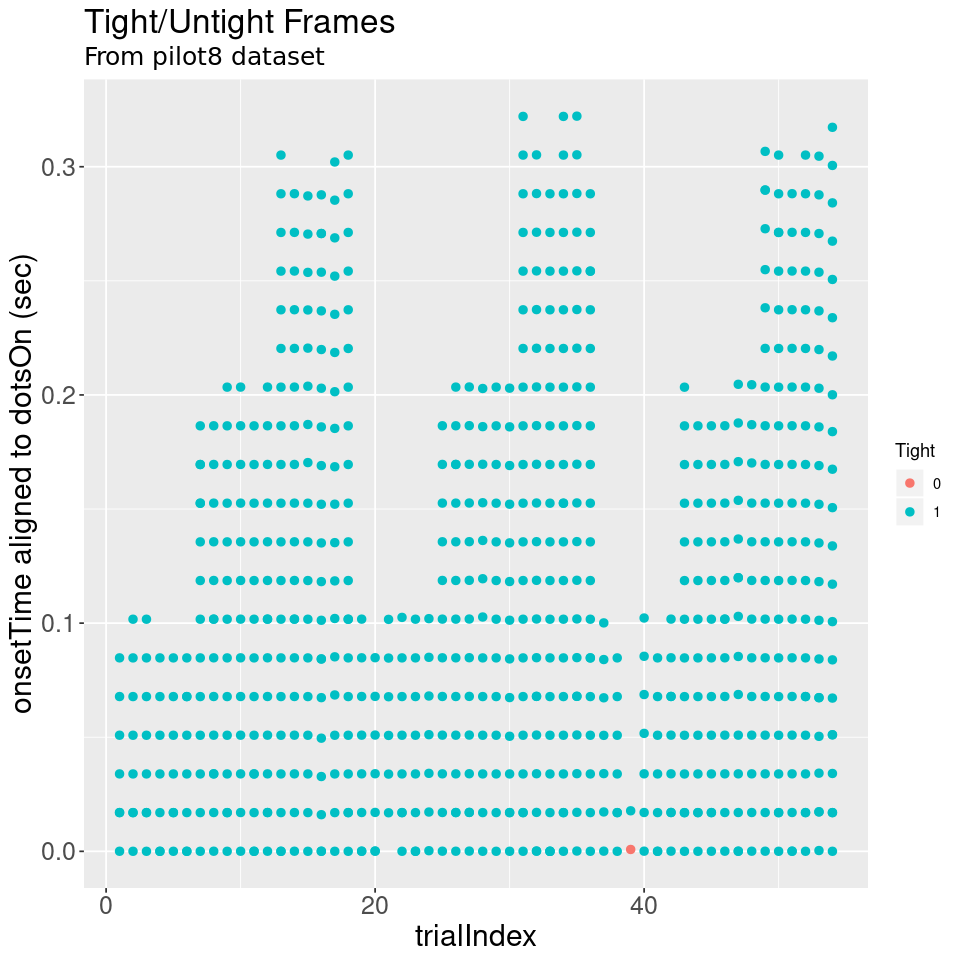

In [22]:
# plot
ggplot(frameTimes, aes(x=trialIndex, y=onsetTime-(dotsOn+trialStart))) + geom_point(aes(col=factor(isTight)), size=2) +
#    geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
#    guides(colour = guide_legend(reverse=T)) +
   labs(title="Tight/Untight Frames",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="onsetTime aligned to dotsOn (sec)",
        color="Tight") + 
   theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

## Exploring match between `FRAMES` and `DOTS`

In [23]:
# unique(tb[[DOTS]][,frameIdx])
# tb[[DOTS]][order(trialIndex),.(frameIdx), by=.(trialIndex, frameIdx)]

# Accuracy analysis
- Accuracy (% correct) on the task

In [24]:
accuracy <- sum(tb[[TRIALS]][,correct])/numTrials
cat(accuracy * 100,"%", sep = '')

33.33333%

- Accuracy on CP vs. non-CP trials

In [25]:
# count CP and Non-CP trials
cpGrouping <- getFreq(tb[[TRIALS]], "presenceCP")
numCPtrials <- cpGrouping[presenceCP == 1, freq.]
numNonCPtrials <- cpGrouping[presenceCP == 0, freq.]

# compute accuracies in each group of trials
accuracy_CP <- sum(tb[[TRIALS]][presenceCP == 1, correct])/numCPtrials * 100
accuracy_nonCP <- sum(tb[[TRIALS]][presenceCP == 0, correct])/numNonCPtrials * 100
# round to 2 decimals
accuracy_CP <- round(accuracy_CP, digits = 2)
accuracy_nonCP <- round(accuracy_nonCP, digits = 2)

# display summarizing table
toDisplay <- cpGrouping[, ("accuracy") := data.frame("accuracy"=c(accuracy_nonCP, accuracy_CP))]
print(toDisplay)
# toDisplay # print a second time because of a bug that I don't fully understand (see https://github.com/IRkernel/IRkernel/issues/127 and https://github.com/rstudio/rmarkdown/issues/1002)

   presenceCP freq. accuracy
1:          0    47    29.79
2:          1     7    57.14


- Accuracy as a function of viewing duration

In [26]:
# first get marginal frequencies
toDisplay <- tb[[TRIALS]][order(viewingDuration),.(freq = .N, correct = sum(correct)), by=viewingDuration]

# then add the accuracy column
toDisplay <- toDisplay[,.(viewingDuration, freq, correct, accuracy = round(correct/freq*100,digits=2))]
toDisplay

viewingDuration,freq,correct,accuracy
0.1,18,8,44.44
0.2,18,4,22.22
0.3,18,6,33.33


- Accuracy as a function of coherence level

In [27]:
# first get marginal frequencies
toDisplay <- tb[[TRIALS]][order(coherence),.(freq = .N, correct = sum(correct)), by=coherence]

# then add the accuracy column
toDisplay <- toDisplay[,.(coherence, freq, correct, accuracy = round(correct/freq*100,digits=2))]
toDisplay

coherence,freq,correct,accuracy
6.4,18,5,27.78
12.8,18,9,50.00
25.6,18,4,22.22


- Group by change point presence after CP time

In [28]:
# first get marginal frequencies
toDisplay <- tb[[TRIALS]][viewingDuration > .2,
                  .(freq = .N, correct = sum(correct)), 
                  by=.(viewingDuration, presenceCP)]
# then add the accuracy column
toDisplay <- toDisplay[,.(viewingDuration, freq, correct, presenceCP,  accuracy = round(correct/freq*100,digits=2))]
toDisplay

viewingDuration,freq,correct,presenceCP,accuracy
0.3,7,4,1,57.14
0.3,11,2,0,18.18


# Reverse Kernel Analysis

Let's display the number of coherent dots on each frames, grouping by subject's choice.

In [29]:
# count coherent dots on each frame
cohDots <- tb[[DOTS]][,.(numCohDots=sum(isCoherent)),by=.(trialCount,frameIdx)]
str(cohDots)
# let's try to sign numCohDots according to the direction of motion (+ for R and - for L)


Classes ‘data.table’ and 'data.frame':	743 obs. of  3 variables:
 $ trialCount: int  1 1 2 2 2 2 2 2 2 3 ...
 $ frameIdx  : int  1 2 1 2 3 4 5 6 7 1 ...
 $ numCohDots: int  14 11 5 15 26 21 21 15 25 13 ...
 - attr(*, ".internal.selfref")=<externalptr> 


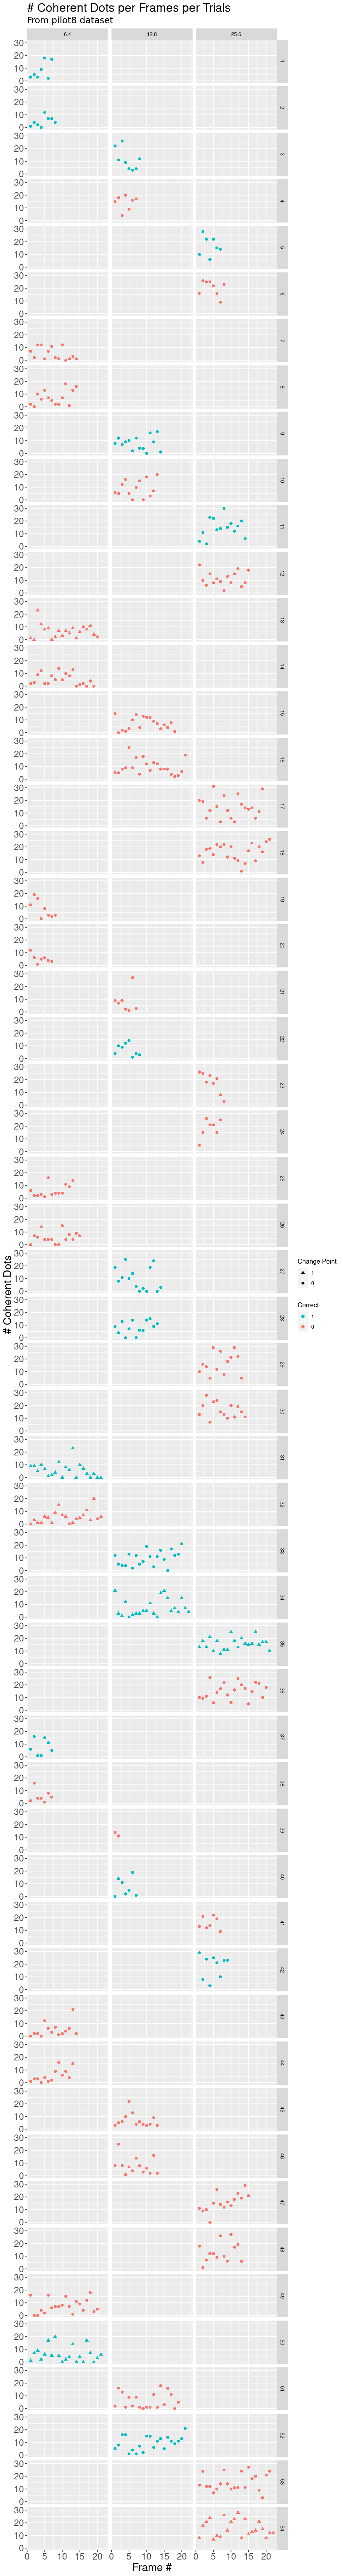

In [30]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=60)

# plot
ggplot(tb[[DOTS]][cohDots,on=c("trialCount","frameIdx")], aes(x=frameIdx, y=numCohDots)) + 
    geom_point(aes(col=factor(correct), shape=factor(presenceCP)), size=2) +
    facet_grid(trialIndex~coherence) +
#    geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    guides(colour = guide_legend(reverse=T), shape = guide_legend(reverse=T)) +
    labs(title="# Coherent Dots per Frames per Trials",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="# Coherent Dots",
         x="Frame #",
         color="Correct", shape="Change Point") + 
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),                                 # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

# Miscellaneous
##  Explore random seed

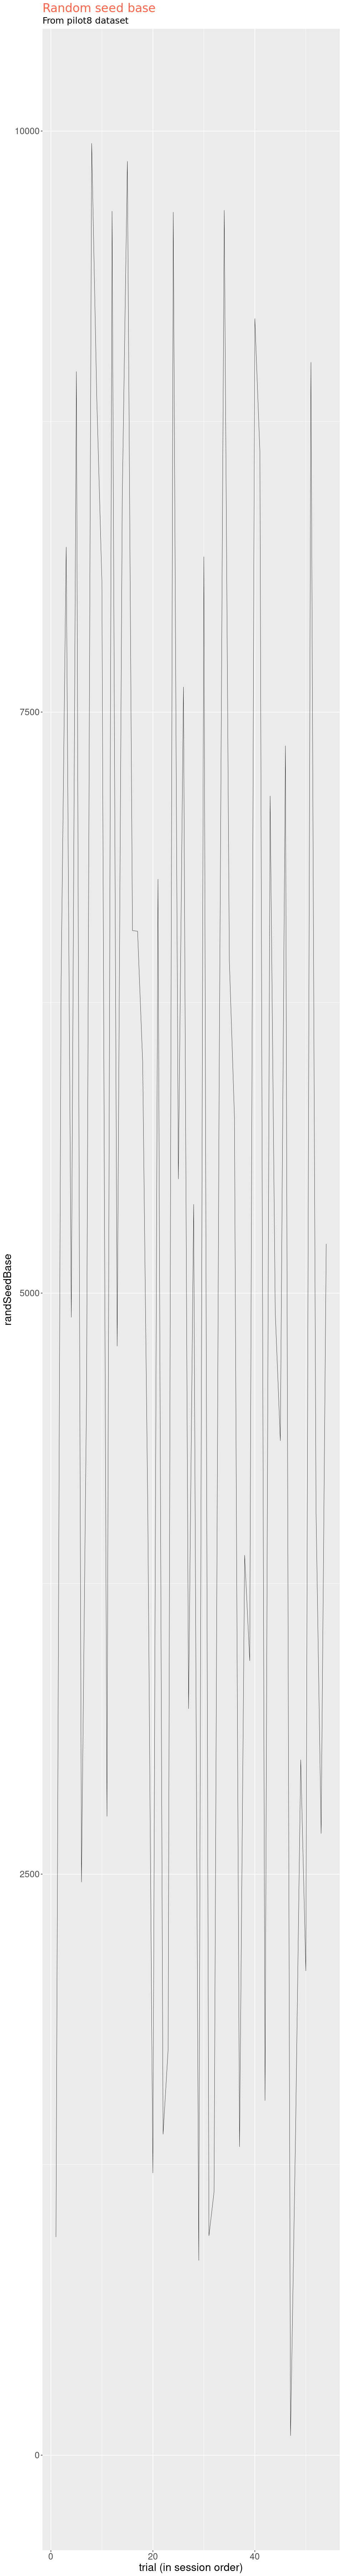

In [31]:
seedTable <- tb[[TRIALS]][,.(randSeedBase,trialIndex),by=trialCount]
g <- ggplot(seedTable, aes(x=trialCount, y=randSeedBase)) + 
  geom_line(size=.2) #+  geom_point(aes(shape=factor(presenceCP), col=factor(viewingDuration)),size=3) 

# Add Title and Labels
g + labs(title="Random seed base", 
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""), 
         y="randSeedBase", 
         x="trial (in session order)") + theme(plot.title=element_text(size=20, 
                                    family="American Typewriter",
                                    color="tomato",
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, 
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text